In [10]:
## Carga de librerias
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import funciones as fn

##Forma
from IPython.display import display, Markdown
palette_color=['#d4afb9', '#d1cfe2', '#9cadce', '#7ec4cf', '#52b2cf']

ModuleNotFoundError: No module named 'plotly'

In [ ]:
##### conectarse a BD #######
conn = sql.connect('Data/db_movies')
cur=conn.cursor()

In [9]:
### para ver las tablas que hay en la base de datos
cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

[('ratings',), ('movies',)]

In [13]:
## traer tabla de BD a python ####
movies= pd.read_sql("select *  from movies", conn)
ratings = pd.read_sql('select * from ratings', conn)

In [14]:
# prompt: Genera un código que muestre esas tablas de datos

print("Movies Table:")
display(movies.head())  # Show the first few rows of the movies table

print("\nRatings Table:")
display(ratings.head())  # Show the first few rows of the ratings table


Movies Table:


,movieId,title,genres,clean_title,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,None,None
1,2,Jumanji (1995),Adventure|Children|Fantasy,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,None,None
4,5,Father of the Bride Part II (1995),Comedy,None,None



Ratings Table:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
def check_df(dataframe):
    # Dimensiones base general
    display(Markdown('**Dimensiones base general**'))
    display(dataframe.shape)

    # Dimensiones sin duplicados
    display(Markdown('**Dimensiones sin duplicados**'))
    display(dataframe.drop_duplicates().shape)

    # Tipos de datos
    display(Markdown('**Tipos**'))
    display(dataframe.dtypes)

    # Valores nulos
    display(Markdown('**Nulos**'))
    display(dataframe.isnull().sum())

check_df(movies)
check_df(ratings)

**Dimensiones base general**

(9742, 5)

**Dimensiones sin duplicados**

(9742, 5)

**Tipos**

movieId         int64
title          object
genres         object
clean_title    object
year           object
dtype: object

**Nulos**

movieId           0
title             0
genres            0
clean_title    9742
year           9742
dtype: int64

**Dimensiones base general**

(100836, 4)

**Dimensiones sin duplicados**

(100836, 4)

**Tipos**

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

**Nulos**

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [16]:
### ver el tipo de datos y faltantes
print(movies.info())
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movieId      9742 non-null   int64 
 1   title        9742 non-null   object
 2   genres       9742 non-null   object
 3   clean_title  0 non-null      object
 4   year         0 non-null      object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [17]:
# distribución de las calificaciones
#muestra cuántas veces aparece cada calificación, ordenadas de la más frecuente a la menos frecuente.
cr=pd.read_sql(""" select rating,
                    count(*) as conteo
                    from ratings
                    group by rating
                    order by conteo desc""", conn)
cr

,rating,conteo
0,4.0,26818
1,3.0,20047
2,5.0,13211
3,3.5,13136
4,4.5,8551
5,2.0,7551
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1370


In [18]:
data  = go.Bar( x=cr.rating,marker_color=palette_color,y=cr.conteo, text=cr.conteo, textposition="outside")
Layout=go.Layout(title="Count of ratings",xaxis={'title':'Rating'},yaxis={'title':'Count'})
go.Figure(data,Layout)

In [19]:
# Cacular cada usuario cuantas peliculas calificó
rating_users = pd.read_sql(''' select userId,
                                count(*) as cnt_rat
                                from ratings
                                group by userId
                                order by cnt_rat asc
                                ''',conn )

In [20]:
rating_users

,userId,cnt_rat
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
605,274,1346
606,448,1864
607,474,2108
608,599,2478


Text(0, 0.5, 'Frecuencia')

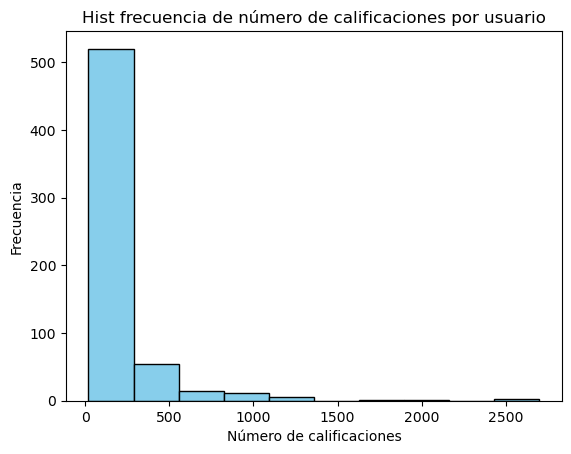

In [21]:
plt.hist(rating_users['cnt_rat'], bins=10, color='skyblue', edgecolor='black')
plt.title('Hist frecuencia de número de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')

In [22]:
fig  = px.histogram(rating_users, x= 'cnt_rat', color_discrete_sequence=palette_color, title= 'Histograma frecuencia de número de calificaciones por usuario')
fig.show()


**Distribución sesgada:** La mayoría de los usuarios han realizado muy pocas calificaciones. La barra más alta está cerca del cero, lo que indica que una gran cantidad de usuarios solo han hecho un número pequeño de calificaciones (probablemente menos de 100).

**Usuarios con más calificaciones:** Aunque la mayoría ha hecho pocas calificaciones, algunos usuarios han hecho un número considerablemente mayor, como se observa en las barras más pequeñas que se extienden hasta 2500 calificaciones.

**Cola larga:** Hay una cola larga a la derecha del gráfico. Esto significa que un pequeño número de usuarios ha realizado una cantidad significativamente mayor de calificaciones en comparación con el resto.

**Interpretación general:** La mayoría de los usuarios son inactivos o califican pocos ítems, mientras que un grupo reducido de usuarios contribuye mucho más a las calificaciones totales. Es una distribución típica de plataformas donde una minoría activa es responsable de una gran cantidad de interacciones.

In [23]:
## Descripción ratings
rating_users.describe()

,userId,cnt_rat
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


Debido a que se obseva que la mayoria de calificaciones estan entre 0 y 500 se

In [24]:
## excluir usuarios con menos de 500 Peliculas calificadas
rating_users2 = pd.read_sql('''select userId,
                                count(*) as cnt_rat
                                from ratings
                                group by userId
                                having cnt_rat <=500
                                order by cnt_rat asc
                                ''',conn )
rating_users2

,userId,cnt_rat
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
562,509,467
563,368,469
564,381,474
565,57,476


In [25]:
rating_users2.describe()

,userId,cnt_rat
count,567.000000,567.000000
mean,303.340388,107.199295
std,174.739864,105.154761
min,1.000000,20.000000
25%,152.500000,34.000000
50%,304.000000,63.000000
75%,453.500000,139.500000
max,609.000000,500.000000


In [26]:
fig  = px.histogram(rating_users2, x= 'cnt_rat', title= 'Histograma frecuencia de número de calificaciones por usuario')
fig.show()

In [27]:
### calificacion de cada pelicula
rating_movie = pd.read_sql('''select movieId,
                                count(*) as cnt_rat
                                from ratings
                                group by movieId
                                order by cnt_rat desc
                                ''',conn )

In [28]:
fig  = px.histogram(rating_movie, x= 'cnt_rat', title= 'Histograma frecuencia de número de calificaciones por pelicula')
fig.show()

In [29]:
rating_movie.describe()

,movieId,cnt_rat
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


In [30]:
####peliculas que tengan más de 10 calificaciones
rating_movie2=pd.read_sql(''' select movieId,
                                count(*) as cnt_rat
                                from ratings
                                group by movieId
                                having cnt_rat >= 10
                                order by cnt_rat desc
                                ''',conn )

In [31]:
fig  = px.histogram(rating_movie2, x= 'cnt_rat', title= 'Histograma frecuencia de número de calificaciones por pelicula')
fig.show()

In [32]:
rating_movie2.describe()

,movieId,cnt_rat
count,2269.000000,2269.000000
mean,20530.586161,35.749669
std,35185.840333,35.986989
min,1.000000,10.000000
25%,1345.000000,14.000000
50%,3256.000000,22.000000
75%,8958.000000,43.000000
max,187593.000000,329.000000


In [33]:
## crear copia de db_books datos originales, nombrarla books2 y procesar books2
conn = sql.connect('Data/db_movies2.db') ### crear cuando no existe el nombre de cd y para conectarse cuando sí existe.
cur = conn.cursor() ###para funciones que ejecutan sql en base de datos

In [35]:
### para ver las tablas que hay en la base de datos
cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('full_ratings',),
 ('full_ratings_sin_dup',),
 ('reco',)]

In [34]:
##### consultar trayendo para pandas ###
df_final = pd.read_sql("select * from full_ratings", conn)
df_final

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996.0,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996.0,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996.0,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982.0,1996-11-05


In [37]:
df_final.dtypes

user_id                int64
movie_id               int64
rating               float64
movie_title           object
movie_genres          object
movie_clean_title     object
movie_year           float64
fecha_nueva           object
dtype: object

In [38]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70529 entries, 0 to 70528
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            70529 non-null  int64  
 1   movie_id           70529 non-null  int64  
 2   rating             70529 non-null  float64
 3   movie_title        70529 non-null  object 
 4   movie_genres       70529 non-null  object 
 5   movie_clean_title  70529 non-null  object 
 6   movie_year         70518 non-null  float64
 7   fecha_nueva        70529 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.3+ MB


In [39]:
# Filtrar las filas donde la columna "movie_year" tenga valores nulos
nulos = df_final[df_final['movie_year'].isnull()]
nulos

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
8444,62,176601,5.0,Black Mirror,(no genres listed),Black Mirror,NaN,2018-05-08
15194,111,171631,1.0,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN,2018-01-31
15196,111,171891,3.5,Generation Iron 2,(no genres listed),Generation Iron 2,NaN,2018-01-31
25473,209,140956,3.5,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-04-23
25524,210,40697,4.0,Babylon 5,Sci-Fi,Babylon 5,NaN,2018-05-25
36779,305,140956,4.5,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-07-31
36897,306,149334,3.0,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN,2018-02-11
53509,462,162414,5.0,Moonlight,Drama,Moonlight,NaN,2016-11-07
59298,514,140956,3.0,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-08-11
61233,528,40697,0.5,Babylon 5,Sci-Fi,Babylon 5,NaN,2014-02-07


In [40]:
# Definir un diccionario de títulos de películas y sus años correspondientes
nuevos_anios = {
    'Babylon 5': 1994,
    'Ready Player One': 2018,
    'Black Mirror': 2018,
    'Maria Bamford: Old Baby': 2017,
    'Generation Iron 2': 2017,
    'Nocturnal Animals': 2016,
    'Moonlight': 2016,
    'Paterson': 2016
}

# Iterar sobre el diccionario y actualizar los años correspondientes en el DataFrame
for titulo, anio in nuevos_anios.items():
    df_final.loc[df_final['movie_title'] == titulo, 'movie_year'] = anio

In [41]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70529 entries, 0 to 70528
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            70529 non-null  int64  
 1   movie_id           70529 non-null  int64  
 2   rating             70529 non-null  float64
 3   movie_title        70529 non-null  object 
 4   movie_genres       70529 non-null  object 
 5   movie_clean_title  70529 non-null  object 
 6   movie_year         70529 non-null  float64
 7   fecha_nueva        70529 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.3+ MB


In [42]:
df_final

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996.0,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996.0,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996.0,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982.0,1996-11-05


In [43]:
# Convertir la columna 'fecha_nueva' a tipo str y eliminar el '.0' al final
df_final['movie_year'] = df_final['movie_year'].astype(str).str[:-2]
# Mostrar el DataFrame actualizado
df_final

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982,1996-11-05


In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70529 entries, 0 to 70528
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            70529 non-null  int64  
 1   movie_id           70529 non-null  int64  
 2   rating             70529 non-null  float64
 3   movie_title        70529 non-null  object 
 4   movie_genres       70529 non-null  object 
 5   movie_clean_title  70529 non-null  object 
 6   movie_year         70529 non-null  object 
 7   fecha_nueva        70529 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 4.3+ MB


In [45]:
# Pasar la variable fecha a formato fecha
df_final['fecha_nueva'] = pd.to_datetime(df_final['fecha_nueva'])
df_final

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982,1996-11-05


In [46]:
# Agrupar por el título de la película y contar el número de ocurrencias
movie_views = df_final.groupby('movie_title')['user_id'].count().sort_values(ascending=False)

# Crear un DataFrame con los datos de las 10 películas más vistas
top_movies = movie_views.head(10).reset_index(name='num_views')

# Graficar el número de vistas por película utilizando Plotly Express
fig = px.bar(top_movies, x='movie_title', y='num_views',
             title='Top 10 Películas Más Vistas',
             labels={'movie_title': 'Película', 'num_views': 'Número de Veces Vista'})
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [47]:
# Agrupar por la fecha nueva y contar el número de películas vistas
movies_by_date = df_final.groupby('fecha_nueva')['movie_title'].count().reset_index()

# Graficar el número de películas vistas por fecha utilizando Plotly Express
fig = px.line(movies_by_date, x='fecha_nueva', y='movie_title',
              title='Cantidad de Películas Vistas por Fecha',
              labels={'fecha_nueva': 'Fecha', 'movie_title': 'Número de Películas Vistas'})
fig.show()

In [57]:
#exportar datos
df_final.to_csv('salidas\\df_final', index=False)